# Jack in the Box


In [ ]:
##############################################################################################
# If you're using Google Colab, uncomment this section by selecting the whole section and press
# ctrl+'/' on your and keyboard. Run it before you start programming, this will enable the nice 
# LaTeX "display()" function for you. If you're using the local Jupyter environment, leave it alone
##############################################################################################
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from math import pi
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.1.1/latest.js?config=TeX-AMS_HTML"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

--_aadaaa### Boilerplate

In [ ]:
def rk4(dxdt, x, dt, t):
  k1 = dt * dxdt(x, t)
  k2 = dt * dxdt(x + k1/2., t + dt/2)
  k3 = dt * dxdt(x + k2/2., t + dt/2)
  k4 = dt * dxdt(x + k3, t + dt)
  x_new = x + (1/6.) * (k1 + 2.* k2 + 2. * k3+k4)
  return(x_new)

def simulate2(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    
    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,i*dt,dt)
        x = np.copy(xtraj[:,i])
    return xtraj  

In [ ]:
# Almost a Carbon Copy of what we did in HW5
def impact_condition(s, phi_func, threshold=1e-1):
    phi_val = phi_func(*s)
    for i in range(phi_val.shape[0]):
        # print("Phi Val", phi_val[i])
        if phi_val[i] > -threshold and phi_val[i] < threshold:
            return (True, i)
    return (False, None)


def impact_update(s, imp_eqs, imp_subs):
  # Substitute First
  substitute_teacher = {xbd_dumb:s[6], ybd_dumb:s[7], tbd_dumb:s[8],
                        xjd_dumb:s[9], yjd_dumb:s[10], tjd_dumb:s[11],
                        xb_dumb:s[0], yb_dumb:s[1], tb_dumb:s[2],
                        xj_dumb:s[3], yj_dumb:s[4], tj_dumb:s[5]}

  substitute_again = {xb_plus:s[0], yb_plus:s[1], tb_plus:s[2],
                      xj_plus:s[3], yj_plus:s[4], tj_plus:s[5]}
  # Teach the impact a lesson
  impact_again = imp_eqs.subs(substitute_teacher)
  impact_again = sym.simplify(impact_again)

  impact_sub_again = impact_again.subs(substitute_again)
  # display(impact_sub_again)
  
  # Let the impact solve some questions on the test
  impact_sols = sym.solve(impact_sub_again, [xb_plus, yb_plus, tb_plus,
                                             xj_plus, yj_plus, tj_plus,
                                             xbd_plus, ybd_plus, tbd_plus,
                                             xjd_plus, yjd_plus, tjd_plus,
                                             lamb], dict=True)
        
  # Check if those solutions are good
  for sol in impact_sols:
    # display("We hit sumthin!", sol)
    lambda_update_sol = sol[lamb]
    # display(lambda_update_sol)
    if abs(lambda_update_sol) < 0.000001:
      print("Yo, that's small")
    else:
        return np.array([s[0], s[1], s[2], s[3], s[4], s[5],
                        sol[xbd_plus], sol[ybd_plus],sol[tbd_plus],
                        sol[xjd_plus], sol[yjd_plus],sol[tjd_plus], ])
                
def simulate_with_impact(f,x0,tspan,dt,integrate,imp_eqs,imp_subs):
    N = int ((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan), max(tspan), N)
    xtraj = np.zeros((len(x0), N))
    t = 0
    for i in range (N):
        t = t+dt
        (impact, which_imp) = impact_condition(x, phi_func, 1e-1)
        # print(f"Impact is {impact} num: {which_imp}")
        if impact is True:
            print(f"Impact is {impact} num: {which_imp}")
            x = impact_update(x, imp_eqs[which_imp], imp_subs)
            xtraj[:,i]=integrate(f, x, dt, t)
            # print("Finished Integration")
        else :
            xtraj[:,i]=integrate(f, x, dt, t)
        x = np.copy(xtraj[:,i])
    return xtraj

### Helper Functions

In [ ]:
# Input: Rotation Angle, 2D Translation Vector
# Returns: SE(3) Matrix
def vecToSE3(theta, vec):
  return sym.Matrix([ [sym.cos(theta), -sym.sin(theta), 0,  vec[0]],
                      [sym.sin(theta),  sym.cos(theta), 0,  vec[1]],
                      [0,                0,             1,       0],
                      [0,                0,             0,       1] ])
  
def npvecToSE3(theta, vec):
  return np.array([ [np.cos(theta), -np.sin(theta), 0,  vec[0]],
                    [np.sin(theta),  np.cos(theta), 0,  vec[1]],
                    [0,                0,             1,     0],
                    [0,                0,             0,     1] ])

# Input: A 3x1 Matrix
# Returns: a 3x3 Matrix
def hat(x):
  return sym.Matrix([ [0, -x[2], x[1]],
                      [x[2], 0, -x[0]],
                      [-x[1], x[0], 0] ])

# Input: A 3x3 Matrix
# Returns: a 3x1 Matrix
def unhat(x):
  return sym.Matrix([ [x[2,1], x[0,2], x[1,0]] ])

# Input: A 4x4 Matrix
# Returns: A 6x1 Matrix
def unhatSE3(x):
  in_ = sym.Matrix([ [x[0,0], x[0,1], x[0,2]], 
                     [x[1,0], x[1,1], x[1,2]],
                     [x[2,0], x[2,1], x[2,2]]
                   ])
  w = unhat(in_)
  v = sym.Matrix([ x[0,3], x[1,3], x[2,3] ])
  return sym.Matrix([ [v[0], v[1], v[2], w[0], w[1], w[2]] ]).T

# Input: A 6x1 Matrix
# Returns: A 4x4 Matrix
def hatSE3(x):
  v = sym.Matrix([ [x[0], x[1], x[2]] ])
  w = sym.Matrix([ [x[3], x[4], x[5]] ])
  w_hat = hat(w)
  return sym.Matrix([ [w_hat[0,0], w_hat[0,1], w_hat[0,2], v[0]],
                      [w_hat[1,0], w_hat[1,1], w_hat[1,2], v[1]],
                      [w_hat[2,0], w_hat[2,1], w_hat[2,2], v[2]],
                      [0,          0,          0,             0]
                    ])
  
def SE3Inv(x):
  R = sym.Matrix([ [x[0,0], x[0,1], x[0,2]],
                   [x[1,0], x[1,1], x[1,2]],
                   [x[2,0], x[2,1], x[2,2]] ])
  
  p = sym.Matrix([ [x[0,3]],
                   [x[1,3]],
                   [x[2,3]] ])
  rhs = R.T
  lhs = -rhs*p
  return sym.Matrix([ [rhs[0,0], rhs[0,1], rhs[0,2], lhs[0]],
                      [rhs[1,0], rhs[1,1], rhs[1,2], lhs[1]],
                      [rhs[2,0], rhs[2,1], rhs[2,2], lhs[2]],
                      [0,         0,          0,          1] ])

def SO3dot(x):
  return x.diff(t)

def SE3dot(x):
  return x.diff(t)

### System Variables and Transformation Frames

In [ ]:
# Define Symbols
t = sym.symbols('t')

# Rather than define symbols, just insert the values
lb = 10 
lj = 1
mb = 1000
mj = 1  
g = 9.8
J_j = 1/12 * (mj*(lj)**2) # Based off moment of inertia 
J_b = 1/12 * (mb*(lb)**2)

# Define the system vars (q)
# Box Vars
xb = sym.Function('x_b')(t)
yb = sym.Function('y_b')(t)
tb = sym.Function('theta_b')(t)
# Jack Vars
xj = sym.Function('x_j')(t)
yj = sym.Function('y_j')(t)
tj = sym.Function('theta_j')(t)

# Transformation Frames
t_wj = vecToSE3(tj, [xj,yj]) # Transform from world -> jack
t_wb = vecToSE3(tb, [xb,yb]) # Transform from world -> Middle of Box

t_bb1 = vecToSE3(0, [lb/2, 0]) # Right
t_bb2 = vecToSE3(0, [0,-lb/2]) # Down
t_bb3 = vecToSE3(0, [-lb/2,0]) # Left
t_bb4 = vecToSE3(0, [0, lb/2]) # Up

t_jj1 = vecToSE3(0, [lj/2, lj/2])  # Right
t_jj2 = vecToSE3(0, [lj/2,-lj/2])  # Down
t_jj3 = vecToSE3(0, [-lj/2,-lj/2]) # Left
t_jj4 = vecToSE3(0, [-lj/2, lj/2]) # Up

# Lets define BOX in terms of WORLD FRAME
t_wb1 = t_wb * t_bb1
t_wb2 = t_wb * t_bb2
t_wb3 = t_wb * t_bb3
t_wb4 = t_wb * t_bb4

print("SE(3) transformation from {W} to {(B)ox}")
display(t_wb)

print("SE(3) transformation from {W} to {(J)ack}")
display(t_wj)

print("SE(3) transformation from {W} to {(B1)ox}")
display(t_wb1)

print("SE(3) transformation from {W} to {(B2)ox}")
display(t_wb2)

print("SE(3) transformation from {W} to {(B3)ox}")
display(t_wb3)

print("SE(3) transformation from {W} to {(B4)ox}")
display(t_wb4)

# Lets define JACK/DICE in terms of WORLD FRAME
t_wj1 = t_wj * t_jj1
t_wj2 = t_wj * t_jj2
t_wj3 = t_wj * t_jj3
t_wj4 = t_wj * t_jj4

print("SE(3) transformation from {W} to {(J1)ack}")
display(t_wj1)

print("SE(3) transformation from {W} to {(J2)ack}")
display(t_wj2)

print("SE(3) transformation from {W} to {(J3)ack}")
display(t_wj3)

print("SE(3) transformation from {W} to {(J4)ack}")
display(t_wj4)

SE(3) transformation from {W} to {(B)ox}


⎡cos(θ_b(t))  -sin(θ_b(t))  0  x_b(t)⎤
⎢                                    ⎥
⎢sin(θ_b(t))  cos(θ_b(t))   0  y_b(t)⎥
⎢                                    ⎥
⎢     0            0        1    0   ⎥
⎢                                    ⎥
⎣     0            0        0    1   ⎦

SE(3) transformation from {W} to {(J)ack}


⎡cos(θ_j(t))  -sin(θ_j(t))  0  x_j(t)⎤
⎢                                    ⎥
⎢sin(θ_j(t))  cos(θ_j(t))   0  y_j(t)⎥
⎢                                    ⎥
⎢     0            0        1    0   ⎥
⎢                                    ⎥
⎣     0            0        0    1   ⎦

SE(3) transformation from {W} to {(B1)ox}


⎡cos(θ_b(t))  -sin(θ_b(t))  0  x_b(t) + 5.0⋅cos(θ_b(t))⎤
⎢                                                      ⎥
⎢sin(θ_b(t))  cos(θ_b(t))   0  y_b(t) + 5.0⋅sin(θ_b(t))⎥
⎢                                                      ⎥
⎢     0            0        1             0            ⎥
⎢                                                      ⎥
⎣     0            0        0             1            ⎦

SE(3) transformation from {W} to {(B2)ox}


⎡cos(θ_b(t))  -sin(θ_b(t))  0  x_b(t) + 5.0⋅sin(θ_b(t))⎤
⎢                                                      ⎥
⎢sin(θ_b(t))  cos(θ_b(t))   0  y_b(t) - 5.0⋅cos(θ_b(t))⎥
⎢                                                      ⎥
⎢     0            0        1             0            ⎥
⎢                                                      ⎥
⎣     0            0        0             1            ⎦

SE(3) transformation from {W} to {(B3)ox}


⎡cos(θ_b(t))  -sin(θ_b(t))  0  x_b(t) - 5.0⋅cos(θ_b(t))⎤
⎢                                                      ⎥
⎢sin(θ_b(t))  cos(θ_b(t))   0  y_b(t) - 5.0⋅sin(θ_b(t))⎥
⎢                                                      ⎥
⎢     0            0        1             0            ⎥
⎢                                                      ⎥
⎣     0            0        0             1            ⎦

SE(3) transformation from {W} to {(B4)ox}


⎡cos(θ_b(t))  -sin(θ_b(t))  0  x_b(t) - 5.0⋅sin(θ_b(t))⎤
⎢                                                      ⎥
⎢sin(θ_b(t))  cos(θ_b(t))   0  y_b(t) + 5.0⋅cos(θ_b(t))⎥
⎢                                                      ⎥
⎢     0            0        1             0            ⎥
⎢                                                      ⎥
⎣     0            0        0             1            ⎦

SE(3) transformation from {W} to {(J1)ack}


⎡cos(θ_j(t))  -sin(θ_j(t))  0  x_j(t) - 0.5⋅sin(θ_j(t)) + 0.5⋅cos(θ_j(t))⎤
⎢                                                                        ⎥
⎢sin(θ_j(t))  cos(θ_j(t))   0  y_j(t) + 0.5⋅sin(θ_j(t)) + 0.5⋅cos(θ_j(t))⎥
⎢                                                                        ⎥
⎢     0            0        1                      0                     ⎥
⎢                                                                        ⎥
⎣     0            0        0                      1                     ⎦

SE(3) transformation from {W} to {(J2)ack}


⎡cos(θ_j(t))  -sin(θ_j(t))  0  x_j(t) + 0.5⋅sin(θ_j(t)) + 0.5⋅cos(θ_j(t))⎤
⎢                                                                        ⎥
⎢sin(θ_j(t))  cos(θ_j(t))   0  y_j(t) + 0.5⋅sin(θ_j(t)) - 0.5⋅cos(θ_j(t))⎥
⎢                                                                        ⎥
⎢     0            0        1                      0                     ⎥
⎢                                                                        ⎥
⎣     0            0        0                      1                     ⎦

SE(3) transformation from {W} to {(J3)ack}


⎡cos(θ_j(t))  -sin(θ_j(t))  0  x_j(t) + 0.5⋅sin(θ_j(t)) - 0.5⋅cos(θ_j(t))⎤
⎢                                                                        ⎥
⎢sin(θ_j(t))  cos(θ_j(t))   0  y_j(t) - 0.5⋅sin(θ_j(t)) - 0.5⋅cos(θ_j(t))⎥
⎢                                                                        ⎥
⎢     0            0        1                      0                     ⎥
⎢                                                                        ⎥
⎣     0            0        0                      1                     ⎦

SE(3) transformation from {W} to {(J4)ack}


⎡cos(θ_j(t))  -sin(θ_j(t))  0  x_j(t) - 0.5⋅sin(θ_j(t)) - 0.5⋅cos(θ_j(t))⎤
⎢                                                                        ⎥
⎢sin(θ_j(t))  cos(θ_j(t))   0  y_j(t) - 0.5⋅sin(θ_j(t)) + 0.5⋅cos(θ_j(t))⎥
⎢                                                                        ⎥
⎢     0            0        1                      0                     ⎥
⎢                                                                        ⎥
⎣     0            0        0                      1                     ⎦

In [ ]:
# Inertia Matrix 1 - For The Jack
In_j = sym.Matrix([[mj,0,0,0,0,0],
                  [0,mj,0,0,0,0],
                  [0,0,mj,0,0,0],
                  [0,0,0,0,0,0],
                  [0,0,0,0,0,0],
                  [0,0,0,0,0,J_j] ])

# Inertia Matrix 2 - For the Box
In_b = sym.Matrix([[mb,0,0,0,0,0],
                   [0,mb,0,0,0,0],
                   [0,0,mb,0,0,0],
                   [0,0,0,0,0,0],
                   [0,0,0,0,0,0],
                   [0,0,0,0,0,J_b] ])


# Twists 
V_wj =  unhatSE3((SE3Inv(t_wj) @ SE3dot(t_wj))) # For Jack
V_wb =  unhatSE3((SE3Inv(t_wb) @ SE3dot(t_wb))) # For Box

print("SE(3) Twist from {W} to {B}")
V_wb = sym.simplify(V_wb)
display(V_wb)

print("SE(3) Twist from {W} to {J}")
V_wj = sym.simplify(V_wj)
display(V_wj)

print("Kinetic Energy")
KE = (1/2 * (V_wj.T @ In_j @ V_wj)) + (1/2 * (V_wb.T @ In_b @ V_wb)) 
KE = sym.simplify(KE[0])
display(KE)

V = mb*g*yb + mj*g*yj
V = sym.simplify(V)
print("V")
display(V)

L = KE - V
L = sym.simplify(L)
print("Lagrangian")
display(L)

SE(3) Twist from {W} to {B}


⎡             d                        d          ⎤
⎢ sin(θ_b(t))⋅──(y_b(t)) + cos(θ_b(t))⋅──(x_b(t)) ⎥
⎢             dt                       dt         ⎥
⎢                                                 ⎥
⎢              d                        d         ⎥
⎢- sin(θ_b(t))⋅──(x_b(t)) + cos(θ_b(t))⋅──(y_b(t))⎥
⎢              dt                       dt        ⎥
⎢                                                 ⎥
⎢                        0                        ⎥
⎢                                                 ⎥
⎢                        0                        ⎥
⎢                                                 ⎥
⎢                        0                        ⎥
⎢                                                 ⎥
⎢                   d                             ⎥
⎢                   ──(θ_b(t))                    ⎥
⎣                   dt                            ⎦

SE(3) Twist from {W} to {J}


⎡             d                        d          ⎤
⎢ sin(θ_j(t))⋅──(y_j(t)) + cos(θ_j(t))⋅──(x_j(t)) ⎥
⎢             dt                       dt         ⎥
⎢                                                 ⎥
⎢              d                        d         ⎥
⎢- sin(θ_j(t))⋅──(x_j(t)) + cos(θ_j(t))⋅──(y_j(t))⎥
⎢              dt                       dt        ⎥
⎢                                                 ⎥
⎢                        0                        ⎥
⎢                                                 ⎥
⎢                        0                        ⎥
⎢                                                 ⎥
⎢                        0                        ⎥
⎢                                                 ⎥
⎢                   d                             ⎥
⎢                   ──(θ_j(t))                    ⎥
⎣                   dt                            ⎦

Kinetic Energy


                             2                                  2             
                 ⎛d         ⎞                       ⎛d         ⎞          ⎛d  
4166.66666666667⋅⎜──(θ_b(t))⎟  + 0.0416666666666667⋅⎜──(θ_j(t))⎟  + 500.0⋅⎜──(
                 ⎝dt        ⎠                       ⎝dt        ⎠          ⎝dt 

        2                   2                     2                   2
       ⎞        ⎛d         ⎞          ⎛d         ⎞        ⎛d         ⎞ 
x_b(t))⎟  + 0.5⋅⎜──(x_j(t))⎟  + 500.0⋅⎜──(y_b(t))⎟  + 0.5⋅⎜──(y_j(t))⎟ 
       ⎠        ⎝dt        ⎠          ⎝dt        ⎠        ⎝dt        ⎠ 

V


9800.0⋅y_b(t) + 9.8⋅y_j(t)

Lagrangian


                                                           2                  
                                               ⎛d         ⎞                   
-9800.0⋅y_b(t) - 9.8⋅y_j(t) + 4166.66666666667⋅⎜──(θ_b(t))⎟  + 0.0416666666666
                                               ⎝dt        ⎠                   

                2                     2                   2                   
    ⎛d         ⎞          ⎛d         ⎞        ⎛d         ⎞          ⎛d        
667⋅⎜──(θ_j(t))⎟  + 500.0⋅⎜──(x_b(t))⎟  + 0.5⋅⎜──(x_j(t))⎟  + 500.0⋅⎜──(y_b(t)
    ⎝dt        ⎠          ⎝dt        ⎠        ⎝dt        ⎠          ⎝dt       

  2                   2
 ⎞        ⎛d         ⎞ 
)⎟  + 0.5⋅⎜──(y_j(t))⎟ 
 ⎠        ⎝dt        ⎠ 

In [ ]:
# Define Symbols for Constraints + Force
# Define lambda 1 - 16
# Define phidd_1 - 16

# Euler Lagrange Calculations
q = sym.Matrix([xb, yb, tb, xj, yj, tj])
q_dot = q.diff(t)
q_ddot = q_dot.diff(t)

L_mat = sym.Matrix([L])

dLdq = L_mat.jacobian(q).T
dLdqd = L_mat.jacobian(q_dot).T
dLdqd_dt = dLdqd.diff(t)
dLdqd_dt = sym.simplify(dLdqd_dt)

el = dLdqd_dt - dLdq
print('\n\033[1m Euler-Lagrange Eq: ')
el = sym.simplify(el)
display(el)

# Forces
Fy = mb*g # Offset Force to Keep Box Up
Ft = sym.cos(pi*t/6) # Force that spins the cup
Amp = 2
FE = sym.Matrix([0, Fy, -10000*Ft, 0, 0, 0]) # Not Iron


# Eqn for LHS and RHS 
lhs = sym.Matrix([*el])
# rhs = sym.Matrix([0, 0, 0, 0, 0, 0]) # For earlier testing
rhs = FE
eqn = sym.Eq(lhs, rhs)
print('\n\033[1m Euler-Lagrange Eq LHS vs RHS: ')
display(eqn)

soln = sym.solve(eqn, q_ddot, dict=True)


 Euler-Lagrange Eq: 


⎡               2              ⎤
⎢              d               ⎥
⎢      1000.0⋅───(x_b(t))      ⎥
⎢               2              ⎥
⎢             dt               ⎥
⎢                              ⎥
⎢          2                   ⎥
⎢         d                    ⎥
⎢ 1000.0⋅───(y_b(t)) + 9800.0  ⎥
⎢          2                   ⎥
⎢        dt                    ⎥
⎢                              ⎥
⎢                    2         ⎥
⎢                   d          ⎥
⎢ 8333.33333333333⋅───(θ_b(t)) ⎥
⎢                    2         ⎥
⎢                  dt          ⎥
⎢                              ⎥
⎢             2                ⎥
⎢            d                 ⎥
⎢       1.0⋅───(x_j(t))        ⎥
⎢             2                ⎥
⎢           dt                 ⎥
⎢                              ⎥
⎢          2                   ⎥
⎢         d                    ⎥
⎢    1.0⋅───(y_j(t)) + 9.8     ⎥
⎢          2                   ⎥
⎢        dt                    ⎥
⎢                              ⎥
⎢         


 Euler-Lagrange Eq LHS vs RHS: 


⎡               2              ⎤                                    
⎢              d               ⎥                                    
⎢      1000.0⋅───(x_b(t))      ⎥                                    
⎢               2              ⎥                                    
⎢             dt               ⎥                                    
⎢                              ⎥                                    
⎢          2                   ⎥                                    
⎢         d                    ⎥                                    
⎢ 1000.0⋅───(y_b(t)) + 9800.0  ⎥                                    
⎢          2                   ⎥                                    
⎢        dt                    ⎥                                    
⎢                              ⎥                                    
⎢                    2         ⎥   ⎡               0               ⎤
⎢                   d          ⎥   ⎢                               ⎥
⎢ 8333.33333333333⋅───(θ_b(t)) ⎥  

In [ ]:
# solver = sym.Matrix([*q_ddot]) # just Q_dot for now, but add in lambdas later
sim_funcs = []
for sol in soln:
  print('\n\033[1mSolution: ')
  for v in q_ddot:
    display(sym.Eq(v,sol[v]))
    sim_funcs.append(sol[v])


Solution: 


  2              
 d               
───(x_b(t)) = 0.0
  2              
dt               

  2              
 d               
───(y_b(t)) = 0.0
  2              
dt               

  2                                        
 d                                         
───(θ_b(t)) = -1.2⋅cos(0.523598775598299⋅t)
  2                                        
dt                                         

  2              
 d               
───(x_j(t)) = 0.0
  2              
dt               

  2               
 d                
───(y_j(t)) = -9.8
  2               
dt                

  2              
 d               
───(θ_j(t)) = 0.0
  2              
dt               

In [ ]:
xb_dd_sol = sim_funcs[0] # For x_box
yb_dd_sol = sim_funcs[1] # For y_box
tb_dd_sol = sim_funcs[2] # For theta_box
xj_dd_sol = sim_funcs[3] # For x_jack
yj_dd_sol = sim_funcs[4] # For y_jack
tj_dd_sol = sim_funcs[5] # For theta_jack

# Lambdified Equations
xb_dd_l = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], q_dot[0], q_dot[1], q_dot[2], q_dot[3], q_dot[4], q_dot[5], t], xb_dd_sol)
yb_dd_l = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], q_dot[0], q_dot[1], q_dot[2], q_dot[3], q_dot[4], q_dot[5], t], yb_dd_sol)
tb_dd_l = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], q_dot[0], q_dot[1], q_dot[2], q_dot[3], q_dot[4], q_dot[5], t], tb_dd_sol)
xj_dd_l = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], q_dot[0], q_dot[1], q_dot[2], q_dot[3], q_dot[4], q_dot[5], t], xj_dd_sol)
yj_dd_l = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], q_dot[0], q_dot[1], q_dot[2], q_dot[3], q_dot[4], q_dot[5], t], yj_dd_sol)
tj_dd_l = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], q_dot[0], q_dot[1], q_dot[2], q_dot[3], q_dot[4], q_dot[5], t], tj_dd_sol)

## Dummy Variables for **Impact**


In [ ]:
xb_dumb, yb_dumb, tb_dumb, xj_dumb, yj_dumb, tj_dumb = sym.symbols(r'x_{box}, y_{box}, \theta_{box}, x_{jack}, y_{jack}, \theta_{jack}')
xbd_dumb, ybd_dumb, tbd_dumb, xjd_dumb, yjd_dumb, tjd_dumb = sym.symbols(r'\dot{x_{box}}, \dot{y_{box}}, \dot{\theta_{box}}, \dot{x_{jack}}, \dot{y_{jack}}, \dot{\theta_{jack}}') 

# Start with Veloicites since they always have a hard time subbing :(! 
dumb_sub = {q_dot[0]:xbd_dumb, q_dot[1]:ybd_dumb, q_dot[2]:tbd_dumb, 
            q_dot[3]:xjd_dumb, q_dot[4]:yjd_dumb, q_dot[5]:tjd_dumb, 
            xb:xb_dumb, yb:yb_dumb, tb:tb_dumb,
            xj:xj_dumb, yj:yj_dumb, tj:tj_dumb,}            

# print('\n\033[1m q and q_dots: ')
display(dumb_sub)
# display(xb_dumb, yb_dumb, tb_dumb, xj_dumb, yj_dumb, tj_dumb)
# display(xbd_dumb, ybd_dumb, tbd_dumb, xjd_dumb, yjd_dumb, tjd_dumb)

⎧                                                                             
⎨θ_b(t): \theta_{box}, θ_j(t): \theta_{jack}, x_b(t): x_{box}, x_j(t): x_{jack
⎩                                                                             

                                      d                               d       
}, y_b(t): y_{box}, y_j(t): y_{jack}, ──(θ_b(t)): \dot{\theta_{box}}, ──(θ_j(t
                                      dt                              dt      

                         d                          d                         
)): \dot{\theta_{jack}}, ──(x_b(t)): \dot{x_{box}}, ──(x_j(t)): \dot{x_{jack}}
                         dt                         dt                        

  d                          d                         ⎫
, ──(y_b(t)): \dot{y_{box}}, ──(y_j(t)): \dot{y_{jack}}⎬
  dt                         dt                        ⎭

In [ ]:
# Impact Transformation Matrices
# From Wall 1 to Jack Vertices
t_b1j1 = SE3Inv(t_wb1) @ t_wj1
t_b1j2 = SE3Inv(t_wb1) @ t_wj2
t_b1j3 = SE3Inv(t_wb1) @ t_wj3
t_b1j4 = SE3Inv(t_wb1) @ t_wj4

# From Wall 2 to Jack Vertices
t_b2j1 = SE3Inv(t_wb2) @ t_wj1
t_b2j2 = SE3Inv(t_wb2) @ t_wj2
t_b2j3 = SE3Inv(t_wb2) @ t_wj3
t_b2j4 = SE3Inv(t_wb2) @ t_wj4
# display(t_b2j1)

# From Wall 3 to Jack Vertices
t_b3j1 = SE3Inv(t_wb3) @ t_wj1
t_b3j2 = SE3Inv(t_wb3) @ t_wj2
t_b3j3 = SE3Inv(t_wb3) @ t_wj3
t_b3j4 = SE3Inv(t_wb3) @ t_wj4

# From Wall 4 to Jack Vertices
t_b4j1 = SE3Inv(t_wb4) @ t_wj1
t_b4j2 = SE3Inv(t_wb4) @ t_wj2
t_b4j3 = SE3Inv(t_wb4) @ t_wj3
t_b4j4 = SE3Inv(t_wb4) @ t_wj4

In [ ]:
t_b1j1_sub = t_b1j1.subs(dumb_sub)
t_b1j2_sub = t_b1j2.subs(dumb_sub)
t_b1j3_sub = t_b1j3.subs(dumb_sub)
t_b1j4_sub = t_b1j4.subs(dumb_sub)

# Consider Impact for First Wall
phi_b1j1 = t_b1j1_sub[0,3]
phi_b1j2 = t_b1j2_sub[0,3]
phi_b1j3 = t_b1j3_sub[0,3]
phi_b1j4 = t_b1j4_sub[0,3]
# display(phi_b1j1)

In [ ]:
t_b2j1_sub = t_b2j1.subs(dumb_sub)
t_b2j2_sub = t_b2j2.subs(dumb_sub)
t_b2j3_sub = t_b2j3.subs(dumb_sub)
t_b2j4_sub = t_b2j4.subs(dumb_sub)

# Consider Impact for Second Wall
phi_b2j1 = t_b2j1_sub[1,3]
phi_b2j2 = t_b2j2_sub[1,3]
phi_b2j3 = t_b2j3_sub[1,3]
phi_b2j4 = t_b2j4_sub[1,3]

In [ ]:
t_b3j1_sub = t_b3j1.subs(dumb_sub)
t_b3j2_sub = t_b3j2.subs(dumb_sub)
t_b3j3_sub = t_b3j3.subs(dumb_sub)
t_b3j4_sub = t_b3j4.subs(dumb_sub)

# Consider Impact for Thirds Wall
phi_b3j1 = t_b3j1_sub[0,3]
phi_b3j2 = t_b3j2_sub[0,3]
phi_b3j3 = t_b3j3_sub[0,3]
phi_b3j4 = t_b3j4_sub[0,3]
# display(phi_b1j1)

In [ ]:
t_b4j1_sub = t_b4j1.subs(dumb_sub)
t_b4j2_sub = t_b4j2.subs(dumb_sub)
t_b4j3_sub = t_b4j3.subs(dumb_sub)
t_b4j4_sub = t_b4j4.subs(dumb_sub)

# Consider Impact for Fourth Wall
phi_b4j1 = t_b4j1_sub[1,3]
phi_b4j2 = t_b4j2_sub[1,3]
phi_b4j3 = t_b4j3_sub[1,3]
phi_b4j4 = t_b4j4_sub[1,3]
# display(phi_b4j1)

## Calculating Impacts
- According to HW5, we started with finding dLdq_dot at - and + (pre/post impact)
- Then we found dPhidq
- Then we found Hamiltonian

In [ ]:
# Create + and - Vars
lamb = sym.symbols(r'\lambda')
xb_min, yb_min, tb_min, xj_min, yj_min, tj_min = sym.symbols(r'x_box^-, y_box^-, \theta_box^-, x_jack^-, y_jack^-, \theta_jack^-')
xb_plus, yb_plus, tb_plus, xj_plus, yj_plus, tj_plus = sym.symbols(r'x_box^+, y_box^+, \theta_box^+, x_jack^+, y_jack^+, \theta_jack^+')
xbd_min, ybd_min, tbd_min = sym.symbols(r'\dot{x_{box}}^-, \dot{y_{box}}^-, \dot{\theta_{box}}^-')
xjd_min, yjd_min, tjd_min = sym.symbols(r'\dot{x_{jack}}^-, \dot{y_{jack}}^-, \dot{\theta_{jack}}^-')
xbd_plus, ybd_plus, tbd_plus = sym.symbols(r'\dot{x_{box}}^+, \dot{y_{box}}^+, \dot{\theta_{box}}^+')
xjd_plus, yjd_plus, tjd_plus = sym.symbols(r'\dot{x_{jack}}^+, \dot{y_{jack}}^+, \dot{\theta_{jack}}^+')

dumb_plus = {xbd_dumb:xbd_plus, ybd_dumb:ybd_plus, tbd_dumb:tbd_plus, xjd_dumb:xjd_plus, yjd_dumb:yjd_plus, tjd_dumb:tjd_plus,
             xb_dumb:xb_plus, yb_dumb:yb_plus, tb_dumb:tb_plus, xj_dumb:xj_plus, yj_dumb:yj_plus, tj_dumb:tj_plus}

dumb_min = {xbd_dumb:xbd_min, ybd_dumb:ybd_min, tbd_dumb:tbd_min, xjd_dumb:xjd_min, yjd_dumb:yjd_min, tjd_dumb:tjd_min,
             xb_dumb:xb_min, yb_dumb:yb_min, tb_dumb:tb_min, xj_dumb:xj_min, yj_dumb:yj_min, tj_dumb:tj_min}

# display(xb_min, yb_min, tb_min, xj_min, yj_min, tj_min)
# display(xb_plus, yb_plus, tb_plus, xj_plus, yj_plus, tj_plus)

# display(xbd_min, ybd_min, tbd_min, xjd_min, yjd_min, tjd_min)
# display(xbd_plus, ybd_plus, tbd_plus, xjd_plus, yjd_plus, tjd_plus)

In [ ]:
# Make sure we have dLdq_dot
# display(dLdq)-> Doesn't depend on any of my variables, so lets not sub
dLdqd_sub = dLdqd.subs(dumb_sub)
display(dLdqd_sub)

dLdqd_min = dLdqd_sub.subs(dumb_min)
print('\n\033[1m dLdqdot_minus: ')
display(dLdqd_min)

# Now we do the same for Plus
dLdqd_plus = dLdqd_sub.subs(dumb_plus)
print('\n\033[1m dLdqdot_plus: ')
display(dLdqd_plus)

⎡         1000.0⋅\dot{x_{box}}         ⎤
⎢                                      ⎥
⎢         1000.0⋅\dot{y_{box}}         ⎥
⎢                                      ⎥
⎢ 8333.33333333333⋅\dot{\theta_{box}}  ⎥
⎢                                      ⎥
⎢          1.0⋅\dot{x_{jack}}          ⎥
⎢                                      ⎥
⎢          1.0⋅\dot{y_{jack}}          ⎥
⎢                                      ⎥
⎣0.0833333333333333⋅\dot{\theta_{jack}}⎦


 dLdqdot_minus: 


⎡         1000.0⋅\dot{x_{box}}__-         ⎤
⎢                                         ⎥
⎢         1000.0⋅\dot{y_{box}}__-         ⎥
⎢                                         ⎥
⎢ 8333.33333333333⋅\dot{\theta_{box}}__-  ⎥
⎢                                         ⎥
⎢          1.0⋅\dot{x_{jack}}__-          ⎥
⎢                                         ⎥
⎢          1.0⋅\dot{y_{jack}}__-          ⎥
⎢                                         ⎥
⎣0.0833333333333333⋅\dot{\theta_{jack}}__-⎦


 dLdqdot_plus: 


⎡         1000.0⋅\dot{x_{box}}__+         ⎤
⎢                                         ⎥
⎢         1000.0⋅\dot{y_{box}}__+         ⎥
⎢                                         ⎥
⎢ 8333.33333333333⋅\dot{\theta_{box}}__+  ⎥
⎢                                         ⎥
⎢          1.0⋅\dot{x_{jack}}__+          ⎥
⎢                                         ⎥
⎢          1.0⋅\dot{y_{jack}}__+          ⎥
⎢                                         ⎥
⎣0.0833333333333333⋅\dot{\theta_{jack}}__+⎦

In [ ]:
# Define dPhi/dq -> Pulled from HW5
phi = sym.Matrix([[phi_b1j1], [phi_b1j2], [phi_b1j3], [phi_b1j4],
                  [phi_b2j1], [phi_b2j2], [phi_b2j3], [phi_b2j4],
                  [phi_b3j1], [phi_b3j2], [phi_b3j3], [phi_b3j4],
                  [phi_b4j1], [phi_b4j2], [phi_b4j3], [phi_b4j4],
                 ])
# display(phi)
dphidq = phi.jacobian([xb_dumb, yb_dumb, tb_dumb, xj_dumb, yj_dumb, tj_dumb])
# display(dphidq)

In [ ]:
# Hamiltonians
Ham = (dLdqd.T * q_dot)[0] - L
Ham = sym.simplify(Ham)

print('\n\033[1m Ham_minus: ')
Ham_dumb = Ham.subs(dumb_sub)
Ham_min = Ham_dumb.subs(dumb_min)
display(Ham_min)

print('\n\033[1m Ham_plus: ')
Ham_plus = Ham_dumb.subs(dumb_plus)
display(Ham_plus)


 Ham_minus: 


                                      2                                       
4166.66666666667⋅\dot{\theta_{box}}__-  + 0.0416666666666667⋅\dot{\theta_{jack

     2                         2                        2                     
}}__-  + 500.0⋅\dot{x_{box}}__-  + 0.5⋅\dot{x_{jack}}__-  + 500.0⋅\dot{y_{box}

    2                        2                                  
}__-  + 0.5⋅\dot{y_{jack}}__-  + 9800.0⋅y_box__- + 9.8⋅y_jack__-


 Ham_plus: 


                                      2                                       
4166.66666666667⋅\dot{\theta_{box}}__+  + 0.0416666666666667⋅\dot{\theta_{jack

     2                         2                        2                     
}}__+  + 500.0⋅\dot{x_{box}}__+  + 0.5⋅\dot{x_{jack}}__+  + 500.0⋅\dot{y_{box}

    2                        2                                  
}__+  + 0.5⋅\dot{y_{jack}}__+  + 9800.0⋅y_box__+ + 9.8⋅y_jack__+

In [ ]:
impact_eqn_lhs = sym.simplify(sym.Matrix([dLdqd_plus - dLdqd_sub,  Ham_plus - Ham_dumb]))
# display(impact_eqn_lhs)

impact_eqns = []
for i in range(phi.shape[0]):
    impact_eqn_rhs = sym.Matrix([lamb * dphidq[i, 0], lamb * dphidq[i, 1],
                                 lamb * dphidq[i, 2], lamb * dphidq[i, 3],
                                 lamb * dphidq[i, 4], lamb * dphidq[i, 5], 0])
    # display(impact_eqn_rhs)
    impact_eqns.append(sym.Eq(impact_eqn_lhs, impact_eqn_rhs))
display(impact_eqns)

⎡⎡                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                                                            
⎢⎢                                     2            

In [ ]:
impact_subs = [xbd_plus, ybd_plus, tbd_plus, xjd_plus, yjd_plus, tjd_plus]

phi_func = sym.lambdify([xb_dumb, yb_dumb, tb_dumb, \
                         xj_dumb, yj_dumb, tj_dumb, \
                         xbd_dumb, ybd_dumb, tbd_dumb,\
                         xjd_dumb, yjd_dumb, tjd_dumb], phi)

# display(impact_subs)
# display(phi_func)

Impact is True num: 6
Impact is True num: 7
Impact is True num: 2
Yo, that's small
Impact is True num: 5
Impact is True num: 10
Yo, that's small
Impact is True num: 9
Yo, that's small
Impact is True num: 8
Yo, that's small
Impact is True num: 3
Impact is True num: 3
Yo, that's small
Impact is True num: 3
Impact is True num: 2
Impact is True num: 14
Yo, that's small
Impact is True num: 6
Impact is True num: 1
Yo, that's small
Impact is True num: 0
Yo, that's small
Impact is True num: 3
Impact is True num: 12
Yo, that's small
Impact is True num: 15
Impact is True num: 10
Yo, that's small
Impact is True num: 9
Impact is True num: 10
Impact is True num: 4
Yo, that's small
Shape of traj:  (12, 1000)


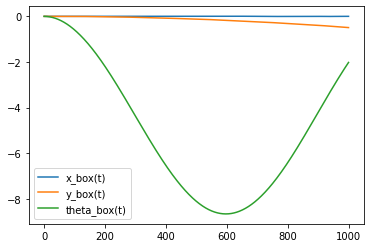

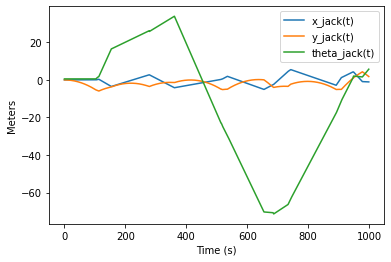

In [ ]:
# Updated dxdt, updated it from HW7 to work for Final Proj
def dxdt(s,t):
  return np.array([s[6], s[7], s[8], s[9], s[10], s[11],
                   xb_dd_l(*s, t), yb_dd_l(*s, t), tb_dd_l(*s, t),
                   xj_dd_l(*s, t), yj_dd_l(*s, t), tj_dd_l(*s, t),
                  ])
  
dt = 0.01
T = 10
s0 = np.array([0, 0, 0, 0, 0, pi/6, 0, 0, 0, 0, 0, 0]) # x, y, th for Box then Jack then Vels
# trajectory = simulate2(dxdt, s0, [0,T], dt, rk4)
trajectory = simulate_with_impact(dxdt, s0, [0,T], dt, rk4, impact_eqns, impact_subs)
print('\033[1mShape of traj: \033[0m', trajectory.shape)
plt.figure()
plt.plot(trajectory[0], label="x_box(t)")
plt.plot(trajectory[1], label="y_box(t)")
plt.plot(trajectory[2], label="theta_box(t)")
plt.legend()
plt.show()

plt.figure()
plt.plot(trajectory[3], label="x_jack(t)")
plt.plot(trajectory[4], label="y_jack(t)")
plt.plot(trajectory[5], label="theta_jack(t)")
plt.xlabel("Time (s)")
plt.ylabel("Meters")
plt.legend()
plt.show()

In [ ]:
def animate_dice(theta_array,L_box=1,L_jack=1,T=10):
    """
    Function to generate web-based animation of a dice, or jack in a cup

    Parameters:
    ================================================
    theta_array:
        trajectory of theta1 and theta2, should be a NumPy array with
        shape of (2,N)
    L_box:
        length of the sides of the box
    L_jack:
        length of the sides of the jack / dice
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data from dice trajectories. Borrows a lot of code from HW7
    xb = theta_array[0]
    yb = theta_array[1]
    tb = theta_array[2]
    # Data of the Jack
    xj = theta_array[3]
    yj = theta_array[4]
    tj = theta_array[5]

    xx1=(xb)
    yy1=(yb)

    xx2=(xj)
    yy2=(yj)

    # xx2=L*np.sin(theta1)
    # xx3=L*np.sin(theta2)

    # Denoting the following points for Box
    # Point 1 x and y
    pb1_x = xx1 + L_box/2*np.cos(tb) - L_box/2*np.sin(tb)
    pb1_y = yy1 + L_box/2*np.sin(tb) + L_box/2*np.cos(tb)

    # Point 2 x and y
    pb2_x = xx1 + L_box/2*np.cos(tb) + L_box/2*np.sin(tb)
    pb2_y = yy1 + L_box/2*np.sin(tb) - L_box/2*np.cos(tb)

    # Point 3 x and y
    pb3_x = xx1 - L_box/2*np.cos(tb) + L_box/2*np.sin(tb)
    pb3_y = yy1 - L_box/2*np.sin(tb) - L_box/2*np.cos(tb)

    # Point 4 x and y
    pb4_x = xx1 - L_box/2*np.sin(tb) - L_box/2*np.cos(tb)
    pb4_y = yy1 - L_box/2*np.sin(tb) + L_box/2*np.cos(tb)

    # Denoting the following points for Jack/Dice
    # Point 1 x and y
    pj1_x = xx2 + L_jack/2*np.cos(tj) - L_jack/2*np.sin(tj)
    pj1_y = yy2 + L_jack/2*np.sin(tj) + L_jack/2*np.cos(tj)

    # Point 2 x and y
    pj2_x = xx2 + L_jack/2*np.cos(tj) + L_jack/2*np.sin(tj)
    pj2_y = yy2 + L_jack/2*np.sin(tj) - L_jack/2*np.cos(tj)

    # Point 3 x and y
    pj3_x = xx2 - L_jack/2*np.cos(tj) + L_jack/2*np.sin(tj)
    pj3_y = yy2 - L_jack/2*np.sin(tj) - L_jack/2*np.cos(tj)

    # Point 4 x and y
    pj4_x = xx2 - L_jack/2*np.sin(tj) - L_jack/2*np.cos(tj)
    pj4_y = yy2 - L_jack/2*np.sin(tj) + L_jack/2*np.cos(tj)

    N = len(theta_array[0]) # Need this for specifying length of simulation

    ###############################################
    # Define arrays containing data for frame axes
    # In each frame, the x and y axis are always fixed
    x_axis = np.array([0.3, 0.0])
    y_axis = np.array([0.0, 0.3])
    # Use homogeneous tranformation to transfer these two axes/points
    # back to the fixed frame
    frame_b_x_axis = np.zeros((2,N))
    frame_b_y_axis = np.zeros((2,N))

    frame_b1_x_axis = np.zeros((2,N))
    frame_b1_y_axis = np.zeros((2,N))

    frame_b2_x_axis = np.zeros((2,N))
    frame_b2_y_axis = np.zeros((2,N))

    frame_b3_x_axis = np.zeros((2,N))
    frame_b3_y_axis = np.zeros((2,N))

    frame_b4_x_axis = np.zeros((2,N))
    frame_b4_y_axis = np.zeros((2,N))

    frame_j_x_axis = np.zeros((2,N))
    frame_j_y_axis = np.zeros((2,N))

    frame_j1_x_axis = np.zeros((2,N))
    frame_j1_y_axis = np.zeros((2,N))

    frame_j2_x_axis = np.zeros((2,N))
    frame_j2_y_axis = np.zeros((2,N))

    frame_j3_x_axis = np.zeros((2,N))
    frame_j3_y_axis = np.zeros((2,N))

    frame_j4_x_axis = np.zeros((2,N))
    frame_j4_y_axis = np.zeros((2,N))


    for i in range(N): # iteration through each time step

        # evaluate homogeneous transformation
        # Would totally use 2D versions of these
        # But I made helper functions for these, so I am going to use them!
        t_wb = npvecToSE3(tb[i], [xb[i],yb[i]])
        t_wj = npvecToSE3(tj[i], [xj[i],yj[i]]) 
  
        # t_bb1 = vecToSE3(0, [lb/2, 0]) # Right
        # t_bb2 = vecToSE3(0, [0,-lb/2]) # Down
        # t_bb3 = vecToSE3(0, [-lb/2,0]) # Left
        # t_bb4 = vecToSE3(0, [0, lb/2]) # Up

    ####################################
    # Using these to specify axis limits.
    xm = -8 #np.min(xx1)-0.5
    xM = 8 #np.max(xx1)+0.5
    ym = -8#np.min(yy1)-2.5
    yM = 8 #np.max(yy1)+1.5

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[
        dict(name='Cup'),
        dict(name='Jack'),
        dict(name='V1'),
        dict(name='V2'),
        dict(name='V3'),
        dict(name='V4'),
        ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(autosize=False, width=1000, height=1000,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Double Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[# first three objects correspond to the arms and two masses,
                       # same order as in the "data" variable defined above (thus 
                       # they will be labeled in the same order)
  
                       dict(x=[pb1_x[k], pb2_x[k], pb3_x[k], pb4_x[k], pb1_x[k]], 
                            y=[pb1_y[k], pb2_y[k], pb3_y[k], pb4_y[k], pb1_y[k]], 
                            mode='lines',
                            line=dict(color='green', width=5),
                            ),
                       
                       dict(x=[pj1_x[k], pj2_x[k], pj3_x[k], pj4_x[k], pj1_x[k]], 
                            y=[pj1_y[k], pj2_y[k], pj3_y[k], pj4_y[k], pj1_y[k]], 
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                      go.Scatter(
                        x=[pj1_x[k]],
                        y=[pj1_y[k]],
                        mode="markers",
                        marker=dict(color="blue", size=6)),
                       
                      go.Scatter(
                        x=[pj2_x[k]],
                        y=[pj2_y[k]],
                        mode="markers",
                        marker=dict(color="blue", size=6)),
                       
                      go.Scatter(
                          x=[pj3_x[k]],
                          y=[pj3_y[k]],
                          mode="markers",
                          marker=dict(color="blue", size=6)),
                      go.Scatter(x=[pj4_x[k]],
                                 y=[pj4_y[k]],
                                 mode="markers",
                                 marker=dict(color="blue", size=6)),
            
                      ]) for k in range(N)]

    pj1_x = xx2 + L_jack/2*np.cos(tj) - L_jack/2*np.sin(tj)
    pj1_y = yy2 + L_jack/2*np.sin(tj) + L_jack/2*np.cos(tj)

    # Point 2 x and y
    pj2_x = xx2 + L_jack/2*np.cos(tj) + L_jack/2*np.sin(tj)
    pj2_y = yy2 + L_jack/2*np.sin(tj) - L_jack/2*np.cos(tj)

    # Point 3 x and y
    pj3_x = xx2 - L_jack/2*np.cos(tj) + L_jack/2*np.sin(tj)
    pj3_y = yy2 - L_jack/2*np.sin(tj) - L_jack/2*np.cos(tj)

    # Point 4 x and y
    pj4_x = xx2 - L_jack/2*np.sin(tj) - L_jack/2*np.cos(tj)
    pj4_y = yy2 - L_jack/2*np.sin(tj) + L_jack/2*np.cos(tj)

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

In [ ]:
animate_dice(trajectory,L_box=10,L_jack=1,T=15)